In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from kret_studies import *
from kret_studies.notebook import *
from kret_studies.complex import *

logger = get_notebook_logger()

Loaded environment variables from /Users/Akseldkw/coding/kretsinger/.env.


INFO:datasets:JAX version 0.7.2 available.


In [ ]:
from kret_studies.kret_torch import ClassificationNN

In [4]:
class ObesityPredNN(ClassificationNN):
    def set_model(self, input_dim: int, num_classes: int) -> None:
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes),
        )

In [5]:
run = start_wandb_run(ObesityPredNN.name(), project="obesity-risk-prediction")

wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
KAGGLE_DIR = DATA_DIR / "kaggle"
OBESITY_DIR = KAGGLE_DIR / "playground-series-s4e2"

In [7]:
df = pd.read_csv(OBESITY_DIR / "train.csv")
df_test = pd.read_csv(OBESITY_DIR / "test.csv")

In [8]:
df.drop(columns=["id"], inplace=True)
df_test.drop(columns=["id"], inplace=True)

uks_pd.data_cleanup(df)
uks_pd.data_cleanup(df_test)

In [9]:
df.sample(4)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
6592,Male,21.077356,1.791315,89.981680,True,True,1.972545,1.163666,Sometimes,False,2.000000,False,0.000000,0.471663,Sometimes,Public_Transportation,Overweight_Level_I
2372,Male,27.000000,1.700000,78.000000,True,False,3.000000,3.000000,Sometimes,False,2.000000,False,0.000000,0.000000,Frequently,Automobile,Overweight_Level_II
4928,Female,18.335019,1.737056,133.903612,True,True,3.000000,3.000000,Sometimes,False,2.862408,False,1.414209,0.778632,Sometimes,Public_Transportation,Obesity_Type_III
20651,Female,22.766227,1.584785,44.009450,False,False,3.000000,3.000000,Frequently,False,2.686824,False,2.000000,0.000000,no,Public_Transportation,Insufficient_Weight


In [10]:
df_test.sample(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
431,Male,33.174147,1.74285,83.016968,True,True,2.0,1.820779,Sometimes,False,2.0,False,2.891986,0.0,Sometimes,Automobile
2747,Male,16.000000,1.70000,65.000000,False,False,2.0,4.000000,Sometimes,False,2.0,False,1.000000,1.0,no,Public_Transportation
10912,Male,23.000000,1.75000,95.000000,True,True,2.0,3.000000,Frequently,False,3.0,False,3.000000,2.0,no,Public_Transportation


In [11]:
X, y = uks_pd.split_x_y(df, "NObeyesdad")

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_val.shape

((16606, 16), (4152, 16))

In [23]:
model = ObesityPredNN(patience=200)

In [24]:
model.set_model(input_dim=X.shape[1], num_classes=y_val.cat.categories.size)
model.post_init()

[2025-11-13 21:33:48,346 | INFO | ObesityPredNN_v000 ] Loaded model weights and state from /Users/Akseldkw/coding/kretsinger/data/pytorch/ObesityPredNN_v000.
[2025-11-13 21:33:48,346 | INFO | ObesityPredNN_v000 ] Full State:
{'hparams': {'batchsize': 128,
             'gamma': 0.1,
             'improvement_tol': 0.0001,
             'lr': 0.001,
             'patience': 200,
             'stepsize': 7},
 'state': {'best_eval_accuracy': '85.98%',
           'best_eval_f1': '85.96%',
           'best_eval_loss': inf,
           'best_eval_r2': '-inf%',
           'epochs_trained': 106}}


In [25]:
model._log = False

In [26]:
model.train_model((X_train, y_train), (X_val, y_val), epochs=5_000, batch_size=320)

 14%|█▍        | 697/5000 [03:34<21:31,  3.33it/s]

[2025-11-13 21:37:28,094 | WARNING | ObesityPredNN_v000 ] Early stopping activated: no improvement for 200 consecutive epochs.


 14%|█▍        | 697/5000 [03:34<22:03,  3.25it/s]


In [27]:
y_true = np.random.randint(0, 5, size=100)
y_pred = np.random.randint(0, 5, size=100)

In [28]:
f1_score(y_true, y_pred, average="weighted")

0.19348305353183398

In [29]:
y_true_copy = y_true.copy()
f1_score(y_true_copy, y_true, average="weighted")

1.0

In [37]:
from sklearn.metrics import confusion_matrix

normalize = "true"  # or 'pred' or 'all' or None
cm = confusion_matrix(y_true, y_pred, normalize=normalize)

class_names = y.cat.categories.to_list()

fig, ax = uks_mpl.subplots(1, 1, 6, 6)
sns.heatmap(
    cm,
    ax=ax,
    annot=True,
    fmt=".2f" if normalize else "d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
title = "Confusion matrix" + (f" (normalize='{normalize}')" if normalize else "")
ax.set_title(title)

Text(0.5, 1.0, "Confusion matrix (normalize='true')")

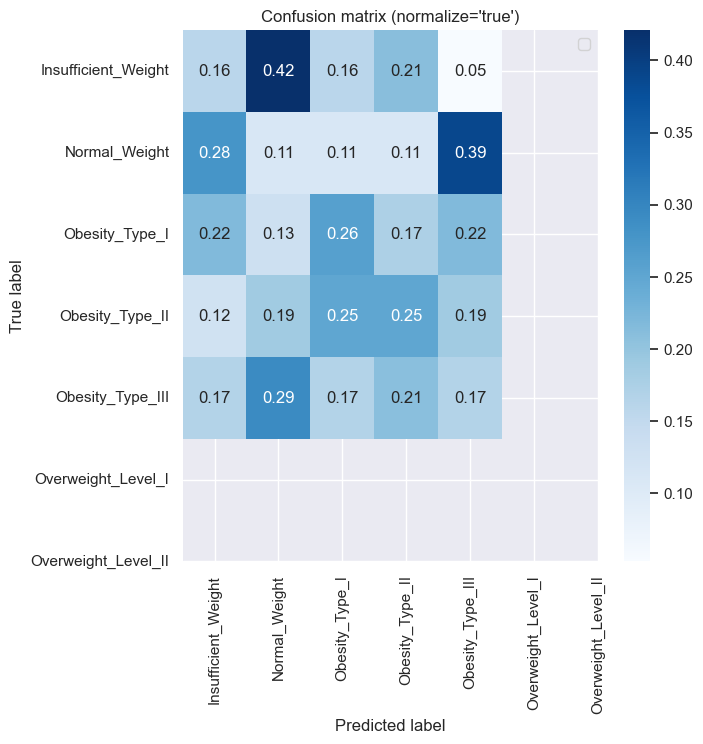

In [38]:
fig

In [40]:
y_pred

array([0, 1, 1, 3, 4, 0, 0, 3, 3, 2, 0, 4, 3, 1, 3, 1, 3, 4, 4, 4, 2, 1,
       1, 1, 1, 3, 3, 4, 0, 2, 0, 1, 0, 4, 4, 2, 2, 1, 2, 3, 0, 2, 2, 4,
       0, 1, 3, 2, 3, 4, 4, 2, 3, 4, 0, 3, 1, 0, 4, 4, 1, 2, 2, 3, 0, 1,
       1, 4, 4, 3, 1, 3, 1, 1, 2, 2, 3, 1, 0, 0, 1, 0, 4, 2, 2, 1, 0, 0,
       2, 0, 4, 0, 4, 3, 1, 2, 1, 3, 2, 4])

In [41]:
y_true

array([1, 1, 3, 2, 2, 1, 2, 0, 1, 0, 1, 2, 4, 4, 3, 0, 0, 3, 4, 3, 4, 4,
       4, 1, 3, 4, 2, 4, 0, 1, 4, 2, 1, 1, 1, 0, 2, 4, 3, 2, 0, 1, 2, 2,
       1, 4, 4, 2, 0, 1, 1, 2, 1, 0, 4, 4, 0, 3, 2, 1, 0, 4, 0, 2, 0, 2,
       2, 1, 4, 3, 0, 4, 0, 3, 3, 3, 3, 0, 4, 2, 0, 4, 3, 2, 3, 4, 2, 2,
       4, 2, 1, 3, 4, 3, 0, 2, 4, 0, 4, 2])

In [39]:
# raise ValueError("STOP")
run.finish()

Eval accuracy,▄▃▃▅▅▅▆▆▁▇▆▇▆▅▇▇▅█▇▅▆▇▆▇▇█▇▄██▇▆▆▆▇█▇▆▆▆
Eval f1,▁▅▆▅▆▅▆▅▆▇▇▇▇▅▇▇█▇▇▇▇▇▇▇▇▇▇▆▇▇▇██▇█▇▆▇▇█
Train loss,█▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Eval accuracy,0.86874
Eval f1,0.86891
Train loss,0.33828
